# First, just the motpy demo
https://github.com/wmuron/motpy

In [21]:
import cv2

import matplotlib.pyplot as plt
import motpy
from motpy import MultiObjectTracker, ModelPreset
from motpy.testing_viz import draw_rectangle, draw_text, image_generator

motpy.set_log_level('DEBUG')


def demo_tracking_visualization(num_steps: int = 1000, num_objects: int = 1):
    gen = image_generator(
        num_steps=num_steps,
        num_objects=num_objects,
        max_omega=0.03,
        miss_prob=0.33,
        disappear_prob=0.00,
        det_err_sigma=3.33)

    dt = 1 / 24
    tracker = MultiObjectTracker(
        dt=dt,
        model_spec=ModelPreset.constant_acceleration_and_static_box_size_2d.value,
        active_tracks_kwargs={'min_steps_alive': 2, 'max_staleness': 6},
        tracker_kwargs={'max_staleness': 12})

    fig = plt.figure(figsize=(45,15))
    
    all_images = []
    
    for i in range(num_steps):
        print(f'Step {i}/{num_steps}')
        img, _, detections = next(gen)

        detections = [d for d in detections if d.box is not None]
        active_tracks = tracker.step(detections=detections)

        error
        for track in active_tracks:
            img = draw_rectangle(img, track.box, color=(10, 10, 220), thickness=5)
            img = draw_text(img, track.id, above_box=track.box)

        for det in detections:
            img = draw_rectangle(img, det.box, color=(10, 220, 20), thickness=2)

#         plt.imshow(img)
#         fig.canvas.draw()
#         fig.canvas.flush_events()
        all_images.append(img)
    
    return all_images


In [22]:

all_images = demo_tracking_visualization(100, 4)

Step 0/100
2020-12-09 15:43:15.855 | DEBUG    | motpy.tracker:__init__:60 - creating new object tracker with {'order_pos': 2, 'dim_pos': 2, 'order_size': 0, 'dim_size': 2} and id 7954b2c9-a0ef-4368-a4e7-61aefa987c7f
2020-12-09 15:43:15.855 | DEBUG    | motpy.tracker:__init__:60 - creating new object tracker with {'order_pos': 2, 'dim_pos': 2, 'order_size': 0, 'dim_size': 2} and id 3de349ff-5634-4f00-a2a4-c65045b634a4


NameError: name 'error' is not defined

<Figure size 3240x1080 with 0 Axes>

In [23]:
%debug

> <ipython-input-21-ada177c3c018>(38)demo_tracking_visualization()
     36         active_tracks = tracker.step(detections=detections)
     37 
---> 38         error
     39         for track in active_tracks:
     40             img = draw_rectangle(img, track.box, color=(10, 10, 220), thickness=5)

ipdb> detections
[(box) [-1.0652339653512723, 395.626505656187, 85.03016129364114, 448.29417484902746],	(score) 0.5716991866497618,	(feature) [87.21622010420937, 225.2377110207311, 123.53007893499732]
, (box) [716.588169543524, 878.1583349412426, 776.3105214147663, 953.5762486732671],	(score) 0.8585545082231842,	(feature) [245.74105017117438, 196.54345552505143, 134.35112160140596]
]
ipdb> q


In [13]:
from ipywidgets import interact, interactive, fixed, interact_manual

def f(t):
    plt.imshow(all_images[t])

interact(f, t=(0,len(all_images)-1))

interactive(children=(IntSlider(value=49, description='t', max=99), Output()), _dom_classes=('widget-interact'…

<function __main__.f(t)>

# Second, actual cellpose detections

In [17]:
# Use the project config file
from DLC_for_WBFM.bin.configuration_definition import *
from DLC_for_WBFM.utils.postprocessing.postprocessing_utils import _get_crop_from_ometiff_virtual
from DLC_for_WBFM.utils.visualization.plot_context_utils import _plot_video_crop_trace
from DLC_for_WBFM.utils.postprocessing.cellpose_utils import *

%load_ext autoreload
%autoreload 2

fname = 'test_project.pickle'
proj = load_config(fname)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### First, get a small number of masks

In [18]:
# Read in a small cube
which_neuron = 1
num_frames = 10

cropped_dat_red = _get_crop_from_ometiff_virtual(fname,
                                   which_neuron=which_neuron,
                                   num_frames=num_frames,
                                                use_red_channel=True)


cropped_dat_green = _get_crop_from_ometiff_virtual(fname,
                                   which_neuron=which_neuron,
                                   num_frames=num_frames,
                                                use_red_channel=False)

# cropped_dat.shape
# cropped_img = np.squeeze(cropped_dat[0,...])

diameter = 8
channels = [0,0]
model = models.Cellpose(gpu=False, model_type='nuclei')

# Get time series of segmentations
all_multi_masks = []

for i in range(num_frames):
    this_vol = np.squeeze(cropped_dat_red[i,...])
    m, f, s, d = model.eval(this_vol, diameter=diameter, channels=channels, do_3D=True)
    
    print(f"{i}/{num_frames}")
    all_multi_masks.append(m)

# Then, get the traces
trace_red = np.zeros(num_frames)
trace_green = np.zeros(num_frames)
num_pixels = np.zeros(num_frames)

for i, m in enumerate(all_multi_masks):
    this_vol_red = np.squeeze(cropped_dat_red[i,...])
    this_vol_green = np.squeeze(cropped_dat_green[i,...])
    # Assume there is only one neuron detected
    trace_red[i] = brightness_from_roi(this_vol_red, m, 1)
    trace_green[i] = brightness_from_roi(this_vol_green, m, 1)
    num_pixels[i] = np.count_nonzero(m)

Cropping 7 slices, starting at 8
Full size read as (700, 900)
Page 3308/330; volume 0/10 to cropped array slice 0
Page 3309/330; volume 0/10 to cropped array slice 1
Page 3310/330; volume 0/10 to cropped array slice 2
Page 3311/330; volume 0/10 to cropped array slice 3
Page 3312/330; volume 0/10 to cropped array slice 4
Page 3313/330; volume 0/10 to cropped array slice 5
Page 3314/330; volume 0/10 to cropped array slice 6
Page 3341/330; volume 1/10 to cropped array slice 0
Page 3342/330; volume 1/10 to cropped array slice 1
Page 3343/330; volume 1/10 to cropped array slice 2
Page 3344/330; volume 1/10 to cropped array slice 3
Page 3345/330; volume 1/10 to cropped array slice 4
Page 3346/330; volume 1/10 to cropped array slice 5
Page 3347/330; volume 1/10 to cropped array slice 6
Page 3374/330; volume 2/10 to cropped array slice 0
Page 3375/330; volume 2/10 to cropped array slice 1
Page 3376/330; volume 2/10 to cropped array slice 2
Page 3377/330; volume 2/10 to cropped array slice 3
Pa

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

cellpose_residual_on_style_on_concatenation_off
processing 1 image(s)
multi-stack tiff read in as having 7 planes 1 channels

 running YX: 7 planes of size (19, 19) 




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


 running ZY: 19 planes of size (7, 19) 




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


 running ZX: 19 planes of size (7, 19) 




100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.99it/s]


flows computed 4.33s
dynamics computed 4.34s
masks computed 4.53s

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


estimated masks for 1 image(s) in 4.56 sec
>>>> TOTAL TIME 4.56 sec
0/10
processing 1 image(s)
multi-stack tiff read in as having 7 planes 1 channels

 running YX: 7 planes of size (19, 19) 




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


 running ZY: 19 planes of size (7, 19) 




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


 running ZX: 19 planes of size (7, 19) 




100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.59it/s]


flows computed 4.14s
dynamics computed 4.15s
masks computed 4.28s
estimated masks for 1 image(s) in 4.31 sec
>>>> TOTAL TIME 4.31 sec
1/10
processing 1 image(s)
multi-stack tiff read in as having 7 planes 1 channels

 running YX: 7 planes of size (19, 19) 




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


 running ZY: 19 planes of size (7, 19) 




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


 running ZX: 19 planes of size (7, 19) 




100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.74it/s]


flows computed 4.04s
dynamics computed 4.04s
masks computed 4.21s
estimated masks for 1 image(s) in 4.23 sec

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


>>>> TOTAL TIME 4.23 sec
2/10
processing 1 image(s)
multi-stack tiff read in as having 7 planes 1 channels

 running YX: 7 planes of size (19, 19) 




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


 running ZY: 19 planes of size (7, 19) 




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


 running ZX: 19 planes of size (7, 19) 




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

flows computed 4.03s
dynamics computed 4.03s
masks computed 4.12s
estimated masks for 1 image(s) in 4.15 sec
>>>> TOTAL TIME 4.15 sec
3/10
processing 1 image(s)
multi-stack tiff read in as having 7 planes 1 channels

 running YX: 7 planes of size (19, 19) 




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


 running ZY: 19 planes of size (7, 19) 




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


 running ZX: 19 planes of size (7, 19) 




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

flows computed 4.09s
dynamics computed 4.10s
masks computed 4.16s
estimated masks for 1 image(s) in 4.18 sec
>>>> TOTAL TIME 4.18 sec
4/10
processing 1 image(s)
multi-stack tiff read in as having 7 planes 1 channels

 running YX: 7 planes of size (19, 19) 




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


 running ZY: 19 planes of size (7, 19) 




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


 running ZX: 19 planes of size (7, 19) 




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

flows computed 4.12s
dynamics computed 4.13s
masks computed 4.21s
estimated masks for 1 image(s) in 4.23 sec
>>>> TOTAL TIME 4.23 sec
5/10
processing 1 image(s)
multi-stack tiff read in as having 7 planes 1 channels

 running YX: 7 planes of size (19, 19) 




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


 running ZY: 19 planes of size (7, 19) 




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


 running ZX: 19 planes of size (7, 19) 




100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.25it/s]


flows computed 4.05s
dynamics computed 4.05s
masks computed 4.16s
estimated masks for 1 image(s) in 4.19 sec
>>>> TOTAL TIME 4.20 sec
6/10
processing 1 image(s)
multi-stack tiff read in as having 7 planes 1 channels

 running YX: 7 planes of size (19, 19) 




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


 running ZY: 19 planes of size (7, 19) 




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


 running ZX: 19 planes of size (7, 19) 




100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.28it/s]


flows computed 4.14s
dynamics computed 4.15s
masks computed 4.30s
estimated masks for 1 image(s) in 4.32 sec

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


>>>> TOTAL TIME 4.32 sec
7/10
processing 1 image(s)
multi-stack tiff read in as having 7 planes 1 channels

 running YX: 7 planes of size (19, 19) 




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


 running ZY: 19 planes of size (7, 19) 




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


 running ZX: 19 planes of size (7, 19) 




100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.53it/s]


flows computed 4.09s
dynamics computed 4.09s
masks computed 4.24s
estimated masks for 1 image(s) in 4.27 sec
>>>> TOTAL TIME 4.27 sec
8/10
processing 1 image(s)
multi-stack tiff read in as having 7 planes 1 channels


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


 running YX: 7 planes of size (19, 19) 




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


 running ZY: 19 planes of size (7, 19) 




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


 running ZX: 19 planes of size (7, 19) 




100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.21it/s]

flows computed 4.17s
dynamics computed 4.18s
masks computed 4.25s
estimated masks for 1 image(s) in 4.27 sec
>>>> TOTAL TIME 4.27 sec
9/10


In [20]:
len(all_multi_masks)

10

### Second, actually track them

In [ ]:
def cellpose_tracking_visualization(all_multi_masks, num_objects = 1):

    num_steps = len(all_multi_masks)
    
    dt = 1 / 24
    tracker = MultiObjectTracker(
        dt=dt,
        model_spec=ModelPreset.constant_acceleration_and_static_box_size_2d.value,
        active_tracks_kwargs={'min_steps_alive': 2, 'max_staleness': 6},
        tracker_kwargs={'max_staleness': 12})
    
    all_images = []
    
    for i in range(num_steps):
        print(f'Step {i}/{num_steps}')
        img, _, detections = next(gen)

        detections = [d for d in detections if d.box is not None]
        active_tracks = tracker.step(detections=detections)

        for track in active_tracks:
            img = draw_rectangle(img, track.box, color=(10, 10, 220), thickness=5)
            img = draw_text(img, track.id, above_box=track.box)

        for det in detections:
            img = draw_rectangle(img, det.box, color=(10, 220, 20), thickness=2)

#         plt.imshow(img)
#         fig.canvas.draw()
#         fig.canvas.flush_events()
        all_images.append(img)
    
    return all_images

# Quick test for bounding boxes

http://scipy-lectures.org/advanced/image_processing/auto_examples/plot_find_object.html

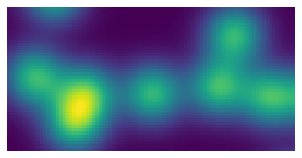

In [24]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt

np.random.seed(1)
n = 10
l = 256
im = np.zeros((l, l))
points = l*np.random.random((2, n**2))
im[(points[0]).astype(np.int), (points[1]).astype(np.int)] = 1
im = ndimage.gaussian_filter(im, sigma=l/(4.*n))

mask = im > im.mean()

label_im, nb_labels = ndimage.label(mask)

# Find the largest connected component
sizes = ndimage.sum(mask, label_im, range(nb_labels + 1))
mask_size = sizes < 1000
remove_pixel = mask_size[label_im]
label_im[remove_pixel] = 0
labels = np.unique(label_im)
label_im = np.searchsorted(labels, label_im)

# Now that we have only one connected component, extract it's bounding box
slice_x, slice_y = ndimage.find_objects(label_im==4)[0]
roi = im[slice_x, slice_y]

plt.figure(figsize=(4, 2))
plt.axes([0, 0, 1, 1])
plt.imshow(roi)
plt.axis('off')

plt.show()

In [27]:
slice_x, slice_y

(slice(80, 124, None), slice(168, 256, None))

In [28]:
ndimage.find_objects?